In [1]:
import csv
import sqlite3
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Parsing Data, Database Creation, Data Processing

In [2]:
def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

Tables to make:

```
[Patients]
    [PatientID] INTEGER NOT NULL PRIMARY KEY
    [Age] REAL NOT NULL
    [Gender] TEXT NOT NULL
    [Married] TEXT NOT NULL
    [WorkType] TEXT NOT NULL
    [ResidenceType] TEXT NOT NULL

[HealthDetails]
    [PatientID] INTEGER NOT NULL PRIMARY KEY FOREIGN KEY TO Patients(PatientID)
    [HeartDisease] INTEGER NOT NULL
    [HyperTension] INTEGER NOT NULL
    [AvgGlucoseLevel] REAL NOT NULL
    [BMI] REAL
    [Smoker] TEXT NOT NULL

[Strokes]
    [PatientID] INTEGER NOT NULL PRIMARY KEY FOREIGN KEY TO Patients(PatientID)
    [Stroke] INTEGER NOT NULL
```

In [3]:
def create_strokes_db(datafile, db_name, delete_db = False):
    
    # Deletes existing database file, if desired
    if delete_db:
        import os
        if os.path.isfile(db_name):
            os.remove(db_name)
        else:
            raise FileNotFoundError(f"{db_name} does not exist.")
    
    # Create connection to database
    conn = sqlite3.connect(db_name)
    
    # Read and parse data
    header = None
    data = []
    with open(datafile) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if header == None:
                header = row
                continue
            data.append(row)

    # Data to insert
    patient_list = [(int(i[0]), i[2], i[1], i[5], i[6], i[7]) for i in data]
    health_dets = [(int(i[0]), i[4], i[3], i[-4], i[-3], i[-2]) for i in data]
    strokes = [(int(i[0]), int(i[-1])) for i in data]
    
    # Create tables
    create_patients_table_sql = """
    CREATE TABLE IF NOT EXISTS [Patients](
        [PatientID] INTEGER NOT NULL PRIMARY KEY,
        [Age] REAL,
        [Gender] TEXT,
        [Married] TEXTL,
        [WorkType] TEXT,
        [ResidenceType] TEXT);"""

    create_healthdetails_table_sql = """
    CREATE TABLE IF NOT EXISTS [HealthDetails](
        [PatientID] INTEGER NOT NULL PRIMARY KEY,
        [HeartDisease] INTEGER,
        [HyperTension] INTEGER,
        [AvgGlucoseLevel] REAL,
        [BMI] REAL,
        [Smoker] TEXT,
        FOREIGN KEY(PatientID) REFERENCES Patients(PatientID));
    """

    create_strokes_table_sql = """
    CREATE TABLE IF NOT EXISTS [Strokes](
        [PatientID] INTEGER NOT NULL PRIMARY KEY,
        [Stroke] INTEGER NOT NULL,
        FOREIGN KEY(PatientID) References Patients(PatientID));
    """
    
    # Insert statements
    insert_patients = """
    INSERT INTO Patients(
        PatientID,
        Age,
        Gender,
        Married,
        WorkType,
        ResidenceType) VALUES (?, ?, ?, ?, ?, ?)"""
    
    insert_healthdetails = """
    INSERT INTO HealthDetails(
        PatientID,
        HeartDisease,
        HyperTension,
        AvgGlucoseLevel,
        BMI,
        Smoker) VALUES (?, ?, ?, ?, ?, ?)"""

    insert_strokes = "INSERT INTO Strokes(PatientID, Stroke) VALUES (?, ?)"
    
    # Create tables and insert values
    with conn:
        cur = conn.cursor()
        create_table(conn, create_patients_table_sql, drop_table_name = "Patients")
        create_table(conn, create_healthdetails_table_sql, drop_table_name = "HealthDetails")
        create_table(conn, create_strokes_table_sql, drop_table_name = "Strokes")

        cur.executemany(insert_patients, patient_list)
        cur.executemany(insert_healthdetails, health_dets)
        cur.executemany(insert_strokes, strokes)
    
    conn.close()

In [12]:
create_strokes_db("stroke_data.csv", "stroke.db", delete_db = False)

In [4]:
conn = sqlite3.connect("stroke.db")

In [5]:
# Check correctly inserted
df = pd.read_sql_query("SELECT * FROM HealthDetails", conn)
df

,PatientID,HeartDisease,HyperTension,AvgGlucoseLevel,BMI,Smoker
0,67,0,0,92.97,N/A,formerly smoked
1,77,0,0,85.81,18.6,Unknown
2,84,0,0,89.17,31.5,never smoked
3,91,0,0,98.53,18.5,never smoked
4,99,0,0,108.89,52.3,Unknown
...,...,...,...,...,...,...
5105,72911,0,1,129.54,60.9,smokes
5106,72914,0,0,90.57,24.2,Unknown
5107,72915,0,0,172.33,45.3,formerly smoked
5108,72918,0,1,62.55,30.3,Unknown


In [6]:
# Join data into one dataframe
join_statement = """
SELECT
    p.PatientID, Age, Gender,
    ResidenceType, HeartDisease, HyperTension,
    AvgGlucoseLevel, BMI, Smoker,
    Stroke
FROM Patients AS p
INNER JOIN HealthDetails AS hd
ON p.PatientID = hd.PatientID
INNER JOIN Strokes AS s
ON s.PatientID = p.PatientID
"""

data = pd.read_sql_query(join_statement, conn)

In [7]:
data.head()

,PatientID,Age,Gender,ResidenceType,HeartDisease,HyperTension,AvgGlucoseLevel,BMI,Smoker,Stroke
0,67,17.0,Female,Urban,0,0,92.97,N/A,formerly smoked,0
1,77,13.0,Female,Rural,0,0,85.81,18.6,Unknown,0
2,84,55.0,Male,Urban,0,0,89.17,31.5,never smoked,0
3,91,42.0,Female,Urban,0,0,98.53,18.5,never smoked,0
4,99,31.0,Female,Urban,0,0,108.89,52.3,Unknown,0


In [8]:
import numpy as np
# Check for missing values
data["BMI"] = data["BMI"].apply(lambda x: np.nan if x == "N/A" else x) # Convert "N/A" to NaN

bmi_female, bmi_male, bmi_other = data[["Gender", "BMI"]].groupby("Gender").mean()["BMI"] # Gender-specific averages
bmi_female, bmi_male, bmi_other

(29.065757680358992, 28.64793635007459, 22.4)

In [77]:
data["Gender"].unique()
data["Smoker"].unique()
data["ResidenceType"].unique()

array(['Female', 'Male'], dtype=object)

array(['formerly smoked', 'Unknown', 'never smoked', 'smokes'],
      dtype=object)

array(['Urban', 'Rural'], dtype=object)

In [10]:
data.head()

,PatientID,Age,Gender,ResidenceType,HeartDisease,HyperTension,AvgGlucoseLevel,BMI,Smoker,Stroke
0,67,17.0,Female,Urban,0,0,92.97,NaN,formerly smoked,0
1,77,13.0,Female,Rural,0,0,85.81,18.6,Unknown,0
2,84,55.0,Male,Urban,0,0,89.17,31.5,never smoked,0
3,91,42.0,Female,Urban,0,0,98.53,18.5,never smoked,0
4,99,31.0,Female,Urban,0,0,108.89,52.3,Unknown,0


In [11]:
# Replace BMI missing values with gender-specific BMI averages
data["BMI"] = np.where((np.isnan(data["BMI"])) & (data["Gender"] == "Female"), bmi_female, data["BMI"])
data["BMI"] = np.where((np.isnan(data["BMI"])) & (data["Gender"] == "Male"), bmi_male, data["BMI"])

In [12]:
data.isna().sum()

PatientID          0
Age                0
Gender             0
ResidenceType      0
HeartDisease       0
HyperTension       0
AvgGlucoseLevel    0
BMI                0
Smoker             0
Stroke             0
dtype: int64

In [13]:
data.loc[data["Gender"] == "Other"]

,PatientID,Age,Gender,ResidenceType,HeartDisease,HyperTension,AvgGlucoseLevel,BMI,Smoker,Stroke
3926,56156,26.0,Other,Rural,0,0,143.33,22.4,formerly smoked,0


In [14]:
# Drop from dataset and reset indices
data.drop(index = 3926, inplace=True)
data.reset_index(drop=True, inplace=True)

In [15]:
data.head()

,PatientID,Age,Gender,ResidenceType,HeartDisease,HyperTension,AvgGlucoseLevel,BMI,Smoker,Stroke
0,67,17.0,Female,Urban,0,0,92.97,29.065758,formerly smoked,0
1,77,13.0,Female,Rural,0,0,85.81,18.600000,Unknown,0
2,84,55.0,Male,Urban,0,0,89.17,31.500000,never smoked,0
3,91,42.0,Female,Urban,0,0,98.53,18.500000,never smoked,0
4,99,31.0,Female,Urban,0,0,108.89,52.300000,Unknown,0


In [215]:
# Save data to csv file; uncomment if needed
#data.to_csv("processed_data.csv", index = False)

In [148]:
# Read data from saved csv, uncomment if needed
data = pd.read_csv("processed_data.csv")

## Basic Data Analysis Section

In [16]:
import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Find size of entire dataset
np.shape(data)[0]
# Find how many had strokes
np.shape(data.loc[data["Stroke"] == 1])[0]

# number of non-strokes is 5109 - 249
np.shape(data)[0] - np.shape(data.loc[data["Stroke"] == 1])[0]

5109

249

4860

In [60]:
# Basic descriptive statistics of Age, AvgGlucoseLevel and BMI; entire dataset
data.describe().drop(columns = "PatientID")[["Age", "AvgGlucoseLevel", "BMI"]]

,Age,AvgGlucoseLevel,BMI
count,5109.000000,5109.000000,5109.000000
mean,43.229986,106.140399,28.892790
std,22.613575,45.285004,7.698351
min,0.080000,55.120000,10.300000
25%,25.000000,77.240000,23.800000
50%,45.000000,91.880000,28.400000
75%,61.000000,114.090000,32.800000
max,82.000000,271.740000,97.600000


In [61]:
# Basic descriptive statistics of numeric columns; grouped by gender
data.groupby(by = "Gender").describe()[["Age", "AvgGlucoseLevel", "BMI"]].T

Gender                      Female         Male
Age             count  2994.000000  2115.000000
                mean     43.757395    42.483385
                std      21.966561    23.484066
                min       0.080000     0.080000
                25%      27.000000    22.000000
                50%      44.000000    46.000000
                75%      61.000000    61.000000
                max      82.000000    82.000000
AvgGlucoseLevel count  2994.000000  2115.000000
                mean    104.057809   109.088520
                std      43.590651    47.434840
                min      55.120000    55.220000
                25%      76.432500    78.370000
                50%      90.755000    93.550000
                75%     112.182500   117.730000
                max     267.760000   271.740000
BMI             count  2994.000000  2115.000000
                mean     29.065758    28.647936
                std       7.978270     7.278566
                min      10.300000    11.500000
                25%      23.425000    24.250000
                50%      28.100000    28.647936
                75%      33.300000    32.200000
                max      78.000000    97.600000

In [63]:
gender_bmi_fig = px.histogram(data, x = "BMI", color="Gender", nbins=100, title = "Histogram of BMI by Gender")
gender_bmi_fig.show()

In [64]:
ht_bmi_fig = px.histogram(data, x = "BMI", color= "HyperTension", nbins=100, title = "Histogram of BMI by HyperTension")
ht_bmi_fig.show()

In [65]:
hd_bmi_fig = px.histogram(data, x = "BMI", color= "HeartDisease", nbins=100, title = "Histogram of BMI by HeartDisease")
hd_bmi_fig.show()

In [66]:
# Visualize strokes data
fig1 = px.pie(data, values='Stroke', names='Gender', title='Strokes by Gender')
fig2 = px.pie(data, values='Stroke', names='HyperTension', title='Strokes by HyperTension')
fig1.show()
fig2.show()

In [67]:
def aggregate_summary(feature):
    """
    Calculates the mean AverageGlucoseLevel, mean BMI, and total number of Strokes,
    grouped by << feature >> (Gender, HyperTension, HeartDisease, ResidenceType, Smoker).
    
    Parameters:
    feature <str>: category of interest in dataframe
    
    Returns:
    agg_summary <dataframe>: dataframe of mean Age, mean AverageGlucoseLevel, mean BMI, total Strokes, grouped by feature
    """
    df1 = data.groupby(feature)["Age"].agg("mean").reset_index()
    df2 = data.groupby(feature)["AvgGlucoseLevel"].agg("mean").reset_index()
    df3 = data.groupby(feature)["BMI"].agg("mean").reset_index()
    df4 = data.groupby(feature)["Stroke"].agg("sum").reset_index()
    
    agg_summary = df1.merge(df2.merge(df3.merge(df4)))
    
    return agg_summary

In [68]:
agg_gender = aggregate_summary("Gender")
agg_ht = aggregate_summary("HyperTension")
agg_hd = aggregate_summary("HeartDisease")
agg_rt = aggregate_summary("ResidenceType")
agg_smoker = aggregate_summary("Smoker")

agg_gender
agg_ht
agg_hd
agg_rt
agg_smoker

,Gender,Age,AvgGlucoseLevel,BMI,Stroke
0,Female,43.757395,104.057809,29.065758,141
1,Male,42.483385,109.088520,28.647936,108


,HyperTension,Age,AvgGlucoseLevel,BMI,Stroke
0,0,41.176318,103.543088,28.487717,183
1,1,62.244980,130.188996,32.643371,66


,HeartDisease,Age,AvgGlucoseLevel,BMI,Stroke
0,0,41.804676,104.388438,28.821757,202
1,1,68.188406,136.818768,30.136643,47


,ResidenceType,Age,AvgGlucoseLevel,BMI,Stroke
0,Rural,42.907537,106.360529,28.894636,114
1,Urban,43.542126,105.927307,28.891003,135


,Smoker,Age,AvgGlucoseLevel,BMI,Stroke
0,Unknown,30.229922,99.601541,25.790913,47
1,formerly smoked,54.962670,112.851640,30.651628,70
2,never smoked,46.744715,107.558092,29.960085,90
3,smokes,47.096324,108.017440,30.432920,42


In [69]:
# aggregate of numeric categories by stroke
agl_stroke = data.groupby("Stroke")["AvgGlucoseLevel"].mean().reset_index()
bmi_stroke = data.groupby("Stroke")["BMI"].mean().reset_index()
age_stroke = data.groupby("Stroke")["Age"].mean().reset_index()

agl_stroke
bmi_stroke
age_stroke

,Stroke,AvgGlucoseLevel
0,0,104.787584
1,1,132.544739


,Stroke,BMI
0,0,28.825118
1,1,30.213621


,Stroke,Age
0,0,41.974831
1,1,67.728193


## Applying Machine Learning Techniques

In [218]:
import sklearn

# Building model
from sklearn import preprocessing
from sklearn.feature_selection import SequentialFeatureSelector

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

### Preprocessing & Feature Selection

In [152]:
# First need to encode categorical variables as numerical
enc = preprocessing.OrdinalEncoder()
enc.fit(data[["Gender", "ResidenceType", "Smoker"]])
transformed_categoricals = enc.transform(data[["Gender", "ResidenceType", "Smoker"]])

OrdinalEncoder()

In [153]:
# Gender: 0 -> Female, 1 -> Male
# ResidenceType: 0 -> Rural, 1 -> Urban
# Smoker: 0 -> Unknown, 1 -> Formerly smoked, 2 -> Never smoked, 3 -> Smokes

data[["Gender", "ResidenceType", "Smoker"]] = transformed_categoricals

In [220]:
data

,PatientID,Age,Gender,ResidenceType,HeartDisease,HyperTension,AvgGlucoseLevel,BMI,Smoker,Stroke
0,67,17.0,0.0,1.0,0,0,92.97,29.065758,1.0,0
1,77,13.0,0.0,0.0,0,0,85.81,18.600000,0.0,0
2,84,55.0,1.0,1.0,0,0,89.17,31.500000,2.0,0
3,91,42.0,0.0,1.0,0,0,98.53,18.500000,2.0,0
4,99,31.0,0.0,1.0,0,0,108.89,52.300000,0.0,0
...,...,...,...,...,...,...,...,...,...,...
5104,72911,57.0,0.0,0.0,0,1,129.54,60.900000,3.0,0
5105,72914,19.0,0.0,1.0,0,0,90.57,24.200000,0.0,0
5106,72915,45.0,0.0,1.0,0,0,172.33,45.300000,1.0,0
5107,72918,53.0,0.0,1.0,0,1,62.55,30.300000,0.0,1


In [242]:
X, y = data[["Age", "Gender", "HeartDisease", "HyperTension", "AvgGlucoseLevel", "BMI", "Smoker"]], data["Stroke"]

In [269]:
# Select features for a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
sfs_knn = SequentialFeatureSelector(knn, direction = "backward", n_features_to_select=4)
sfs_knn.fit(X, y)

sfs_knn.get_support()

SequentialFeatureSelector(direction='backward',
                          estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=4)

array([False,  True, False,  True,  True, False,  True])

In [270]:
# Select features for a logistic regression model
log_reg = LogisticRegression(max_iter = 400, class_weight = "balanced") # use balanced class weight because imbalanced data
sfs_lr = SequentialFeatureSelector(log_reg, direction = "backward", n_features_to_select=4)
sfs_lr.fit(X, y)

sfs_lr.get_support()

SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(class_weight='balanced',
                                                       max_iter=400),
                          n_features_to_select=4)

array([False,  True,  True,  True, False, False,  True])

---

#### Logistic Regression


In [282]:
# Transform data to only include selected features
transf_X_lr = sfs_lr.transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(transf_X_lr, y, test_size = 0.2, random_state = 100)

In [283]:
# Scale data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [286]:
# Fit LR model to train and test data
log_reg.fit(X_train, y_train)

# Predict on whole test set
y_pred = log_reg.predict(X_test)

LogisticRegression(class_weight='balanced', max_iter=400)

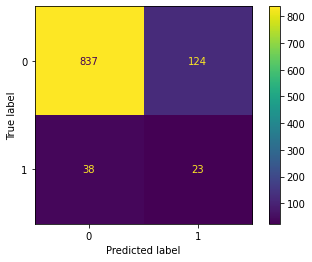

In [287]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC')

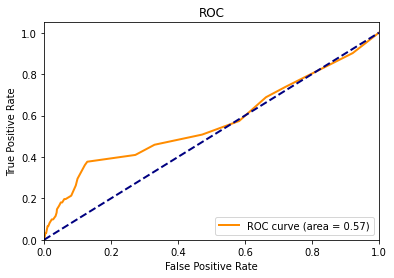

In [304]:
# ROC curve
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

In [309]:
y_pred_prob

array([0.42083286, 0.39829324, 0.71346539, ..., 0.42083286, 0.40951553,
       0.39133358])

<Figure size 720x576 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Logistic Regression Precision-Recall Curve')

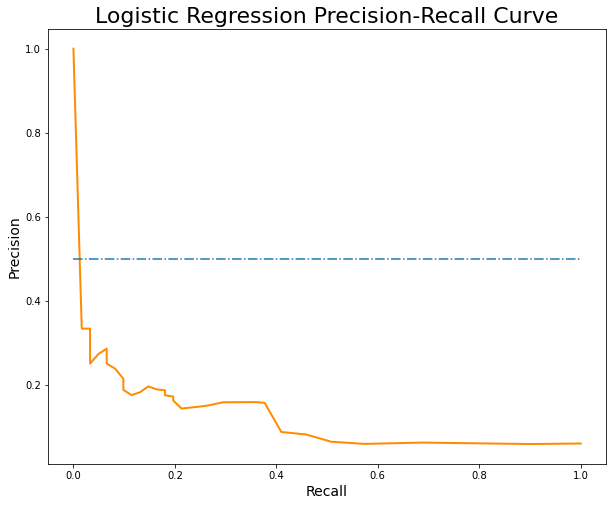

In [325]:
# Precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
pr_score = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize = (10,8))
plt.plot(
    recall,
    precision,
    color = "darkorange",
    lw = 2,)
plt.plot([0, 1], [0.5, 0.5], linestyle = "-.")  #baseline
plt.xlabel('Recall', fontsize = 14)
plt.ylabel('Precision', fontsize = 14)
plt.title('Logistic Regression Precision-Recall Curve', fontsize = 22)

In [326]:
pr_score

0.11273476254808237

---

### k-Nearest Neighbors Classifier

In [316]:
# Transform data to only include selected features for knn
transf_X_knn = sfs_knn.transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(transf_X_knn, y, test_size = 0.2, random_state = 100)

# Scale data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit knn classifier
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [320]:
# Predict using fitted model
y_pred_knn = knn.predict(X_test)
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]

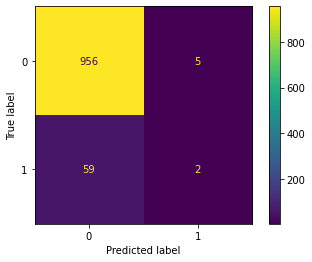

In [321]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.show()

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC')

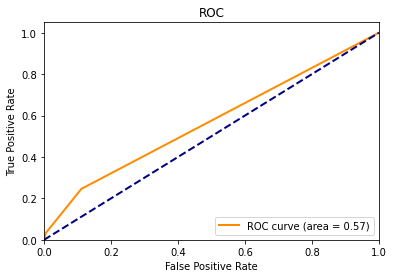

In [322]:
# ROC curve
roc_auc = roc_auc_score(y_test, y_pred_prob_knn)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

<Figure size 720x576 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'KNN Precision-Recall Curve')

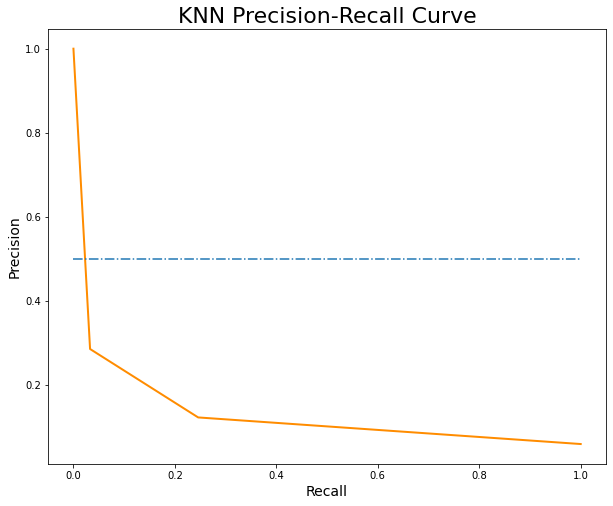

In [327]:
# Precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_knn, pos_label = 1)
pr_score = average_precision_score(y_test, y_pred_prob_knn)
plt.figure(figsize = (10,8))
plt.plot(
    recall,
    precision,
    color = "darkorange",
    lw = 2,)
plt.plot([0, 1], [0.5, 0.5], linestyle = "-.")  #baseline
plt.xlabel('Recall', fontsize = 14)
plt.ylabel('Precision', fontsize = 14)
plt.title('KNN Precision-Recall Curve', fontsize = 22)

In [328]:
pr_score

0.08058009993525928